In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

In [2]:
#Load the dataset
data = pd.read_csv('train.csv', parse_dates=['pickup_datetime', 'dropoff_datetime'])

In [3]:
#Preprocess the dataset
# Calculate trip_duration in minutes
data['trip_duration'] = data['trip_duration'] / 60

# Extract relevant features
data['pickup_hour'] = data['pickup_datetime'].dt.hour
data['pickup_day'] = data['pickup_datetime'].dt.dayofweek
data = data[['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'trip_duration', 'pickup_hour', 'pickup_day']]

# Scale the dataset
scaler = MinMaxScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)

In [4]:
#Split the dataset into training and testing sets
X = data_scaled.drop('trip_duration', axis=1)
y = data_scaled['trip_duration']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
#Build and train the Autoencoder model
input_dim = X_train.shape[1]
encoding_dim = int(input_dim / 2)

input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation='relu')(input_layer)
decoder = Dense(input_dim, activation='sigmoid')(encoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

autoencoder.compile(optimizer=Adam(lr=0.001), loss='mean_squared_error')

history = autoencoder.fit(X_train, X_train, epochs=100, batch_size=128, validation_data=(X_test, X_test), verbose=1)


C:\Users\Professional\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
9117/9117 [==============================] - 32s 3ms/step - loss: 0.0179 - val_loss: 0.0126
Epoch 2/100
9117/9117 [==============================] - 29s 3ms/step - loss: 0.0126 - val_loss: 0.0125
Epoch 3/100
9117/9117 [==============================] - 29s 3ms/step - loss: 0.0125 - val_loss: 0.0125
Epoch 4/100
9117/9117 [==============================] - 30s 3ms/step - loss: 0.0125 - val_loss: 0.0125
Epoch 5/100
9117/9117 [==============================] - 30s 3ms/step - loss: 0.0125 - val_loss: 0.0125
Epoch 6/100
9117/9117 [==============================] - 29s 3ms/step - loss: 0.0125 - val_loss: 0.0125
Epoch 7/100
9117/9117 [==============================] - 30s 3ms/step - loss: 0.0125 - val_loss: 0.0125
Epoch 8/100
9117/9117 [==============================] - 28s 3ms/step - loss: 0.0125 - val_loss: 0.0125
Epoch 9/100
9117/9117 [==============================] - 29s 3ms/step - loss: 0.0125 - val_loss: 0.0125
Epoch 10/100
9117/9117 [==============================] - 29s 3m

9117/9117 [==============================] - 29s 3ms/step - loss: 0.0125 - val_loss: 0.0125
Epoch 80/100
9117/9117 [==============================] - 29s 3ms/step - loss: 0.0125 - val_loss: 0.0125
Epoch 81/100
9117/9117 [==============================] - 30s 3ms/step - loss: 0.0125 - val_loss: 0.0125
Epoch 82/100
9117/9117 [==============================] - 30s 3ms/step - loss: 0.0125 - val_loss: 0.0125
Epoch 83/100
9117/9117 [==============================] - 29s 3ms/step - loss: 0.0125 - val_loss: 0.0125
Epoch 84/100
9117/9117 [==============================] - 31s 3ms/step - loss: 0.0125 - val_loss: 0.0125
Epoch 85/100
9117/9117 [==============================] - 30s 3ms/step - loss: 0.0125 - val_loss: 0.0125
Epoch 86/100
9117/9117 [==============================] - 30s 3ms/step - loss: 0.0125 - val_loss: 0.0125
Epoch 87/100
9117/9117 [==============================] - 31s 3ms/step - loss: 0.0125 - val_loss: 0.0125
Epoch 88/100
9117/9117 [==============================] - 33s 4ms/st

In [7]:
#Evaluate the model
X_train_pred = autoencoder.predict(X_train)
X_test_pred = autoencoder.predict(X_test)

train_mse = np.mean(np.power(X_train - X_train_pred, 2), axis=1)
test_mse = np.mean(np.power(X_test - X_test_pred, 2), axis=1)

mse_threshold = np.quantile(train_mse, 0.90)

y_pred_train = [1 if mse > mse_threshold else 0 for mse in train_mse]
y_pred_test = [1 if mse > mse_threshold else 0 for mse in test_mse]

y_train_binary = np.where(y_train > 7200, 1, 0)
y_test_binary = np.where(y_test > 7200, 1, 0)

print("Training set accuracy: {:.3f}".format(accuracy_score(y_train_binary, y_pred_train)))
print("Test set accuracy: {:.3f}".format(accuracy_score(y_test_binary, y_pred_test)))

9117/9117 [==============================] - 10s 1ms/step
Training set accuracy: 0.900
Test set accuracy: 0.900


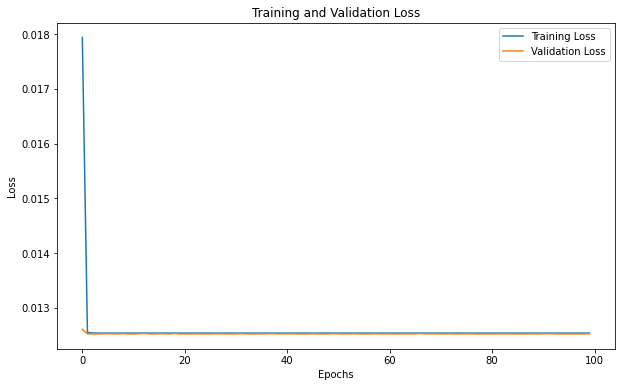

In [8]:
#Visualize the results
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

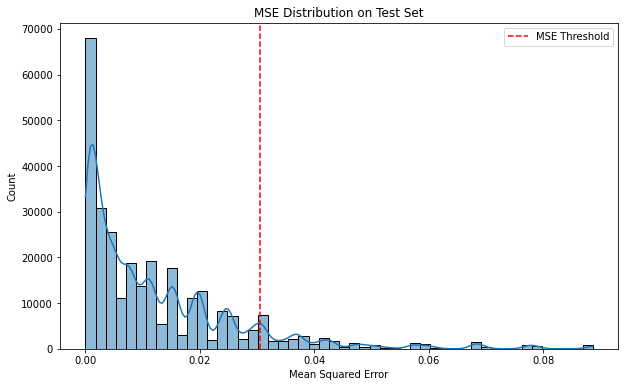

In [9]:
# Visualize the distribution of MSE on the test set
plt.figure(figsize=(10, 6))
sns.histplot(test_mse, kde=True, bins=50)
plt.axvline(x=mse_threshold, color='r', linestyle='--', label='MSE Threshold')
plt.title('MSE Distribution on Test Set')
plt.xlabel('Mean Squared Error')
plt.legend()
plt.show()

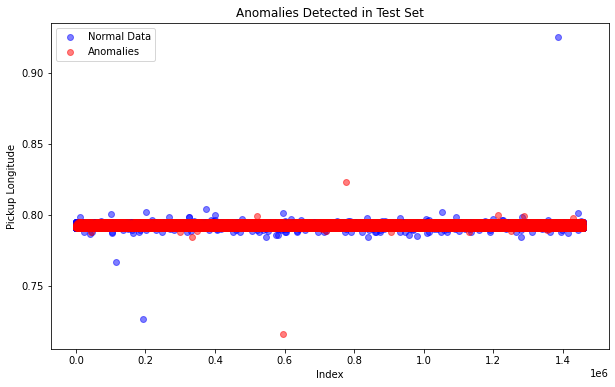

In [11]:
# Visualize the anomalies on a scatter plot
y_pred_test = np.array(y_pred_test)
anomalies = X_test.iloc[y_pred_test == 1]
normal_data = X_test.iloc[y_pred_test == 0]

plt.figure(figsize=(10, 6))
plt.scatter(normal_data.index, normal_data['pickup_longitude'], c='b', label='Normal Data', alpha=0.5)
plt.scatter(anomalies.index, anomalies['pickup_longitude'], c='r', label='Anomalies', alpha=0.5)
plt.title('Anomalies Detected in Test Set')
plt.xlabel('Index')
plt.ylabel('Pickup Longitude')
plt.legend()
plt.show()